# Colony Counter : Exploratory Data Analysis

This notebook explore the Data of our colony counter dataset.

**Goals:**
- Understand dataset structure and label distribution  
- Check for missing or corrupted samples  
- Inspect image quality (brightness/contrast)  
- Visualize representative wells


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

# ML utility
from sklearn.model_selection import train_test_split

### Dataset importation

In [2]:

CSV_PATH = "data/dataset.csv" 

df = pd.read_csv(CSV_PATH)

print("\nColumns:")
print(df.columns.to_list())

print(f"Loaded {len(df)} samples ✔️")

print("\nSample rows:")
df.head()


Columns:
['filename', 'value', 'path', 'plate_type', 'plate_id', 'well']
Loaded 792 samples ✔️

Sample rows:


,filename,value,path,plate_type,plate_id,well
0,Brisbane_plate3_C1.jpg,-1,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,C1
1,Brisbane_plate3_A3.jpg,2,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,A3
2,Brisbane_plate3_A1.jpg,-1,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,A1
3,Brisbane_plate3_B1.jpg,-1,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,B1
4,Brisbane_plate3_B4.jpg,1,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,B4


## Dataset Overview & Label Distributions (Handling `-1` Unreadable Cases)

In this section, we analyze the dataset structure and label distribution, taking into account that:
- `value = -1` represents wells that are **too full to count** and should be considered as a separate class.
  
We will:
- inspect dataset consistency,
- visualize distributions where `-1` is shown separately on the right,
- and analyze how uncountable wells relate to plate types and plates.

This helps detect label imbalance, dataset health, and potential biases between readable and unreadable wells.


### Basic Stats (excluding -1)

In [11]:
readable_df = df[df['value'] != -1]

print("Statistics for COUNTABLE wells:")
readable_df['value'].describe()

Statistics for COUNTABLE wells:


count    618.000000
mean       6.464401
std       15.016669
min        0.000000
25%        0.000000
50%        0.000000
75%        4.000000
max      110.000000
Name: value, dtype: float64

In [12]:
print("Missing values per column:")
df.isna().sum()


Missing values per column:


filename      0
value         0
path          0
plate_type    0
plate_id      0
well          0
dtype: int64

In [13]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,filename,value,path,plate_type,plate_id,well


### Unique Values & Value Categories

In [14]:
unique_values = df['value'].unique()
print("Unique 'value' entries:", np.sort(unique_values))
print("\nNumber of unique entries:", len(unique_values))

print("\nCount of UNREADABLE samples (value = -1):", (df['value'] == -1).sum())
print("Count of READABLE samples:", (df['value'] != -1).sum())


Unique 'value' entries: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  39  40  41  42  45  46  47  49  51  53  54  55  56  57  58  60
  61  65  75  92  94 102 107 110]

Number of unique entries: 62

Count of UNREADABLE samples (value = -1): 174
Count of READABLE samples: 618


### Label distribution

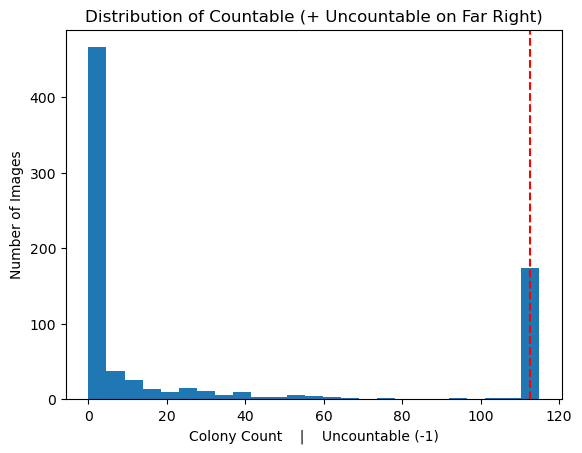


Distribution including -1:
value
-1      174
 0      379
 1       38
 2       24
 3       14
       ... 
 92       1
 94       1
 102      1
 107      1
 110      1
Name: count, Length: 62, dtype: int64


In [15]:
# Build a sequence where -1 sits far to the right
vals = df['value'].copy()

# Map -1 to a large synthetic position for visualization
PLOT_MAX = vals[vals != -1].max() + 5
vals_for_plot = vals.replace(-1, PLOT_MAX)

plt.hist(vals_for_plot, bins=25)
plt.title("Distribution of Countable (+ Uncountable on Far Right)")
plt.xlabel("Colony Count    |    Uncountable (-1)")
plt.ylabel("Number of Images")

# vertical line to highlight where uncountable sits
plt.axvline(PLOT_MAX - 2.5, color='red', linestyle='--')
plt.show()

print("\nDistribution including -1:")
print(df['value'].value_counts().sort_index())

### Plate type distribution 

In [16]:
plate_stats = df.groupby('plate_type')['value'].agg(
    total="count",
    uncountable=lambda x: (x == -1).sum(),
    readable=lambda x: (x != -1).sum(),
    mean_count=lambda x: x[x != -1].mean()
)

plate_stats['uncountable_ratio'] = plate_stats['uncountable'] / plate_stats['total']

plate_stats.sort_values(by='uncountable_ratio', ascending=False)



,total,uncountable,readable,mean_count,uncountable_ratio
plate_type,,,,,
PR8v,168,99,69,12.231884,0.589286
IBV,84,33,51,14.901961,0.392857
Brisbane,120,27,93,13.612903,0.225000
Panama,144,6,138,2.724638,0.041667
PR8,276,9,267,2.805243,0.032609


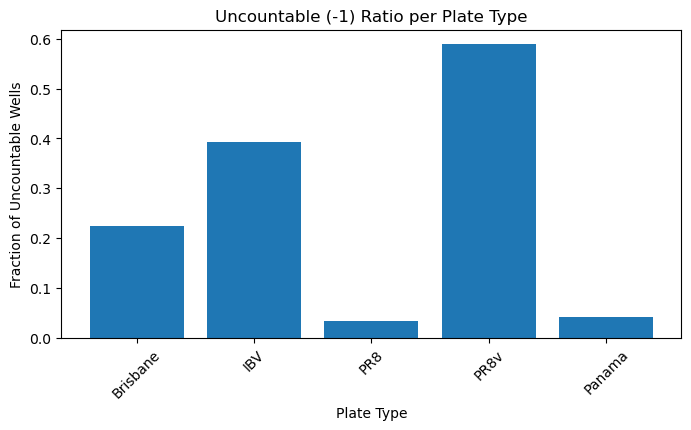

In [17]:
plt.figure(figsize=(8,4))
plt.bar(plate_stats.index, plate_stats['uncountable_ratio'])
plt.title("Uncountable (-1) Ratio per Plate Type")
plt.ylabel("Fraction of Uncountable Wells")
plt.xlabel("Plate Type")
plt.xticks(rotation=45)
plt.show()



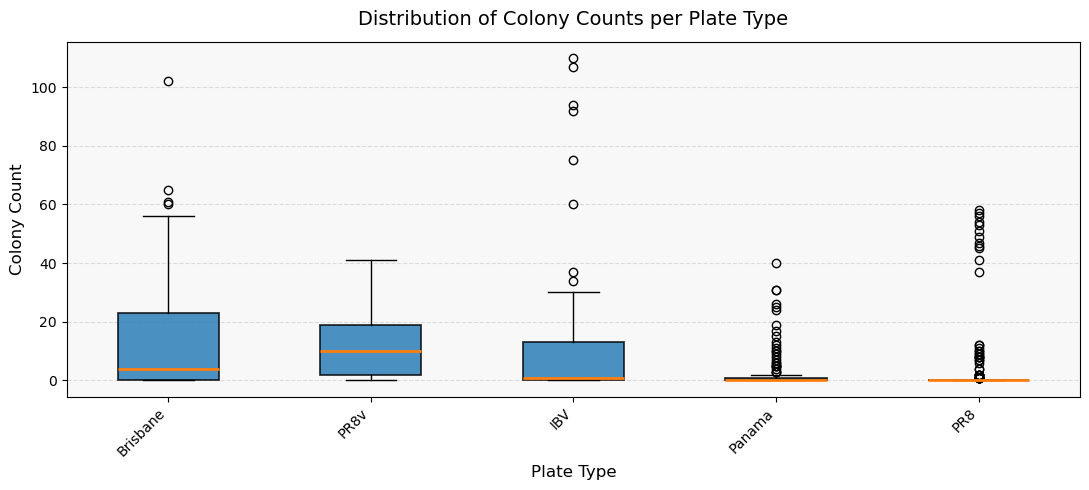

In [18]:
# Filter only readable wells
readable_df = df[df['value'] >= 0]

# Extract plate types
types = readable_df['plate_type'].unique()

# Prepare values grouped by plate type
data_groups = [readable_df[readable_df['plate_type'] == t]['value'] for t in types]

plt.figure(figsize=(11,5))

# Create boxplot with modern Matplotlib style
box = plt.boxplot(
    data_groups,
    patch_artist=True,   # allows box face coloring
    medianprops={'linewidth': 2},
)

# Light gray grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add subtle background shadow behind boxes
for b in box['boxes']:
    b.set_alpha(0.8)  # slight transparency
    b.set_linewidth(1.3)
    b.set_edgecolor("black")

# Add a soft drop shadow rectangle behind the plot
plt.gca().set_facecolor('#f8f8f8')  # creamy background

plt.title("Distribution of Colony Counts per Plate Type", fontsize=14, pad=12)
plt.ylabel("Colony Count", fontsize=12)
plt.xlabel("Plate Type", fontsize=12)

# Display plate types on x-axis
plt.xticks(np.arange(1, len(types)+1), types, rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Interpretation

In general we can see a high imbalance with way more 0 labels than other numbers which could lead to overfitting

## Image Quality Analysis: Brightness, Contrast & Outliers

To better understand the dataset beyond labels, we now examine core image properties:
- overall brightness,
- pixel contrast,
- variability across plate types,
- and extreme cases that might correspond to unreadable wells.

This helps answer questions like:
- Are uncountable wells overexposed or underexposed?
- Are some plate types systematically darker?
- Do anomaly images exist that should be removed or corrected?

We compute brightness and contrast for each image and visualize their distributions, as well as potential correlations with labels.
